In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils

ucsd_data = utils.Dataset("ucsd")

In [3]:
import numpy as np
import pandas as pd
from typing import Type


def evaluate_model(
    model_cls: Type[utils.BaseModel], data: utils.Dataset
) -> pd.DataFrame:
    """
    Train a model of the given class on the given data and evaluate it with 5-fold cross-validation.
    The hyperparameters of the model should be the default ones.
    The return value is a DataFrame with the average metrics for each chapter from the 5 folds.
    """
    feature_cols = data.feature_cols
    all_chapter_metrics: list[list[dict[str, float]]] = [[] for _ in range(12)]

    # Split the data into 5 folds for cross-validation
    # We explicitly set the random_state to get reproducible results
    folds = data.generate_k_fold(5, random_state=0)
    for fold in folds:
        model = model_cls(feature_cols)
        model.fit(fold.train[feature_cols], fold.train["label"])

        chapter_metrics = utils.compute_chapter_metrics(
            model, fold.test[feature_cols], fold.test["label"]
        )
        for i, chapter_metric in enumerate(chapter_metrics):
            all_chapter_metrics[i].append(chapter_metric)

    # Compute the average and standard deviation of the each metric
    metric_names = all_chapter_metrics[0][0].keys() - {"Chapter"}
    chapter_average_metrics = []
    chapter_std_metrics = []

    for chapter_metrics in all_chapter_metrics:
        average_metrics = {
            metric_name: np.mean([m[metric_name] for m in chapter_metrics])
            for metric_name in metric_names
        }
        std_metrics = {
            metric_name: np.std([m[metric_name] for m in chapter_metrics])
            for metric_name in metric_names
        }
        chapter_average_metrics.append(average_metrics)
        chapter_std_metrics.append(std_metrics)

    # Average metrics table
    table = pd.DataFrame(chapter_average_metrics)
    table["Model"] = model_cls.name
    table["Chapter"] = table.index + 1

    return table, model

In [5]:
original_metrics, base_model = evaluate_model(utils.BaseModel, ucsd_data)

In [6]:
original_metrics

,F1,ROC_AUC,PR_AUC,Precision,Recall,Accuracy,Model,Chapter
0,0.000000,0.520776,0.440726,0.000000,0.000000,0.639339,Original,1
1,0.000000,0.668082,0.618659,0.000000,0.000000,0.639339,Original,2
2,0.000000,0.691987,0.644070,0.000000,0.000000,0.639339,Original,3
3,0.000000,0.700500,0.636225,0.000000,0.000000,0.639339,Original,4
4,0.000000,0.710217,0.642074,0.000000,0.000000,0.639339,Original,5
5,0.000000,0.704203,0.612481,0.000000,0.000000,0.639339,Original,6
6,0.000000,0.742521,0.669583,0.000000,0.000000,0.639339,Original,7
7,0.281316,0.795837,0.753199,0.800000,0.183516,0.705405,Original,8
8,0.356022,0.847936,0.791515,0.875000,0.245055,0.716517,Original,9
9,0.605897,0.871283,0.825675,0.844271,0.486813,0.781832,Original,10


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_theme(style="ticks")
sns.set_context("talk")


def plot_feature_importance(model: utils.BaseModel) -> None:
    feature_importance = model.model.named_steps["model"].feature_importances_
    feature_importance = feature_importance.reshape(12, -1).mean(axis=0)

    # Sort the features by importance in descending order
    sorted_indices = feature_importance.argsort()[::-1]
    sorted_feature_importance = feature_importance[sorted_indices]
    sorted_feature_names = [model.feature_cols[i] for i in sorted_indices]
    sorted_feature_names = [c.split("_", 1)[-1] for c in sorted_feature_names]

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=sorted_feature_importance, y=sorted_feature_names, ax=ax)
    ax.set_title("Feature Importance")
    ax.set_xlabel("MDI")
    ax.set_ylabel("Feature")
    plt.show()

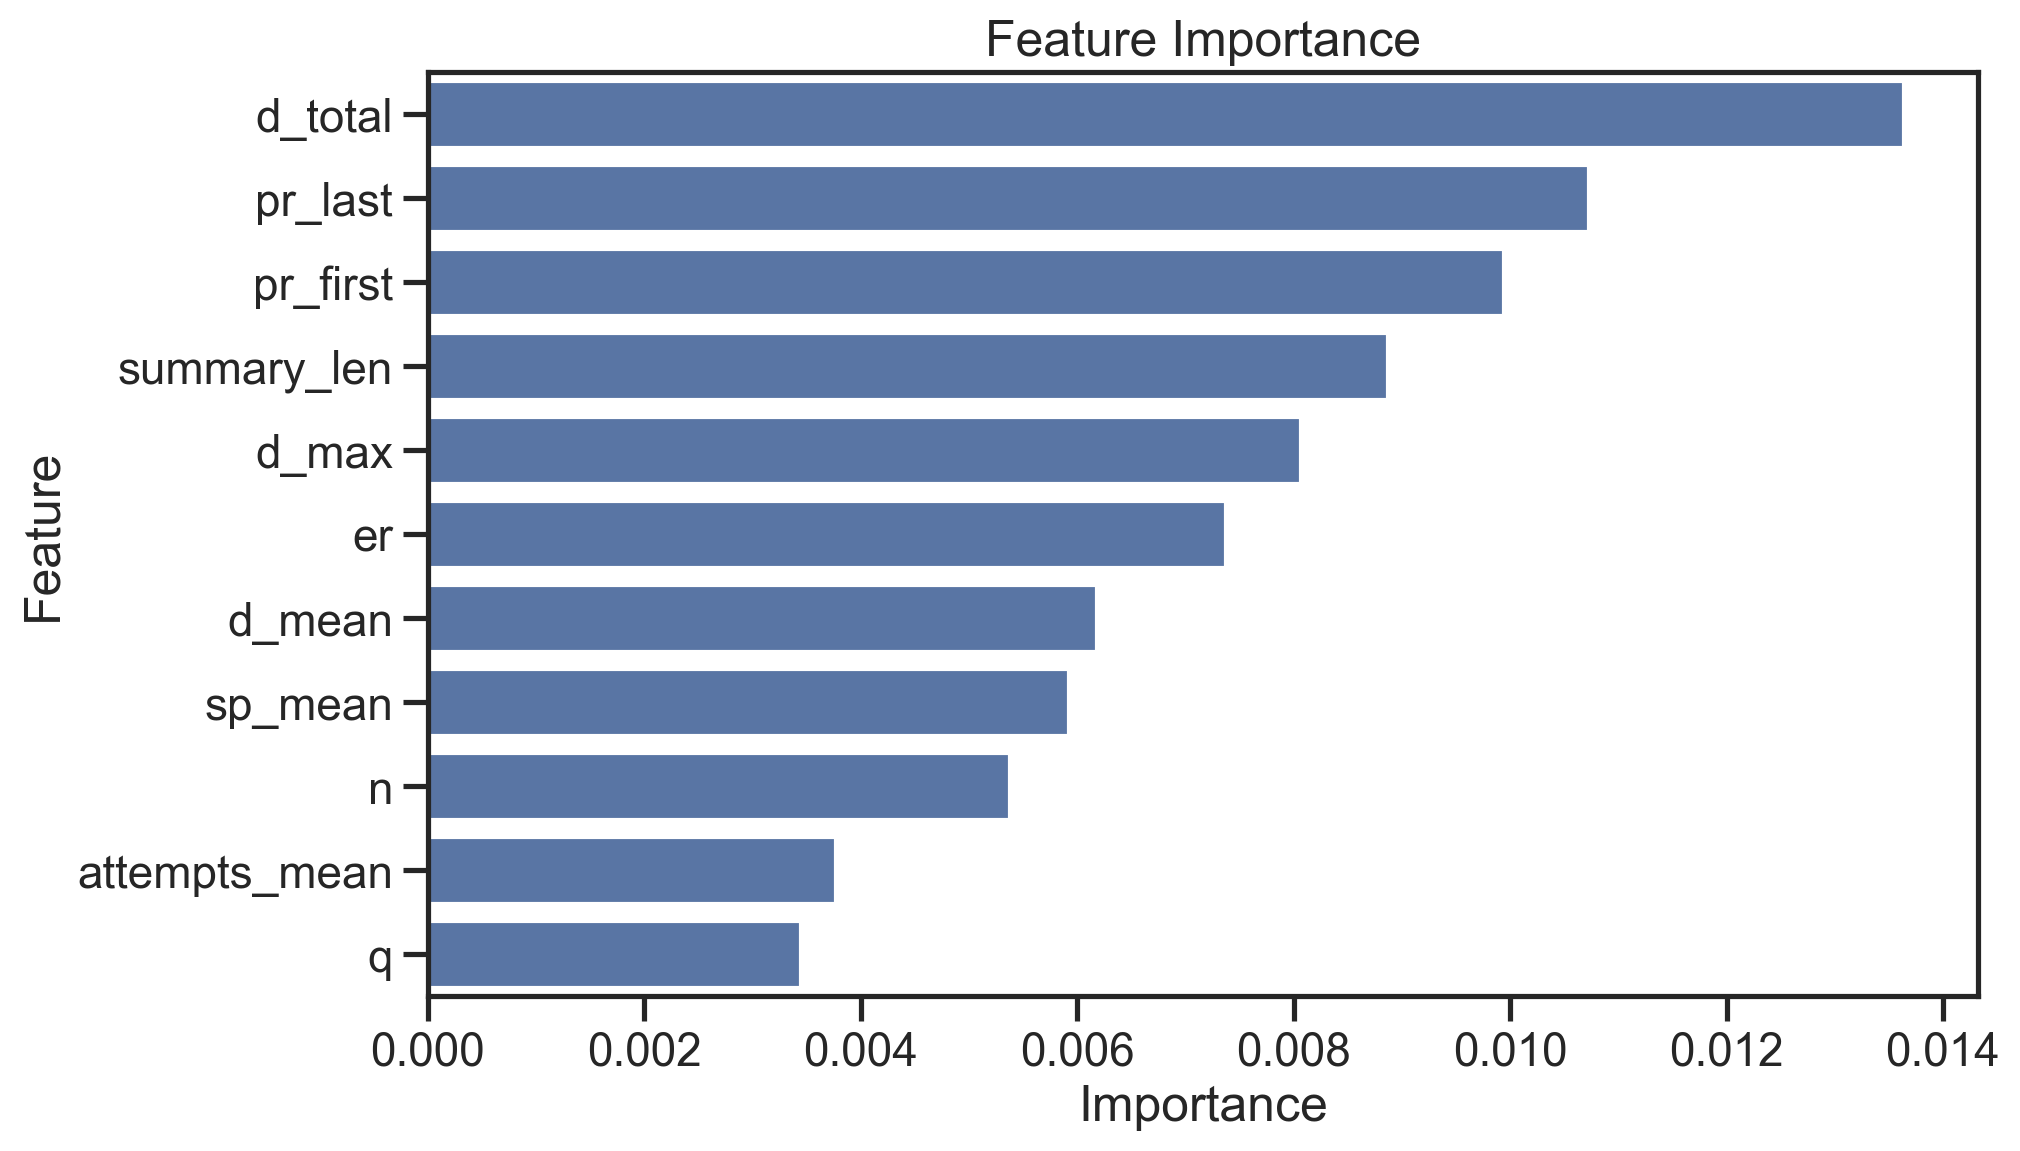

In [13]:
plot_feature_importance(base_model)

In [11]:
import re


class AugmentedModel(utils.BaseModel):
    """
    The underlying model is the same as the BaseModel (RandomForestClassifier),
    but the input data is augmented to simulate the reading progress.
    """

    name = "Augmented"

    def __init__(self, feature_cols):
        super().__init__(feature_cols)

    def fit(self, X, y):
        # Augment the X to simulate the reading progress
        dfs = []
        for chapter in range(1, 13):
            features_to_mask = [
                f for f in self.feature_cols if int(re.findall(r"\d+", f)[0]) > chapter
            ]
            X_masked = X.copy()
            X_masked[features_to_mask] = np.nan
            dfs.append(X_masked)

        # Concatenate the masked dataframes and labels
        augmented_x = pd.concat(dfs, ignore_index=True)
        augmented_y = pd.concat([y] * 12, ignore_index=True)

        # Shuffle augmented x and y at the same time to avoid misalignment
        augmented_x = augmented_x.sample(frac=1)
        augmented_y = augmented_y[augmented_x.index]

        self.model.fit(augmented_x, augmented_y)

In [28]:
augmented_metrics, augmented_model = evaluate_model(AugmentedModel, ucsd_data)

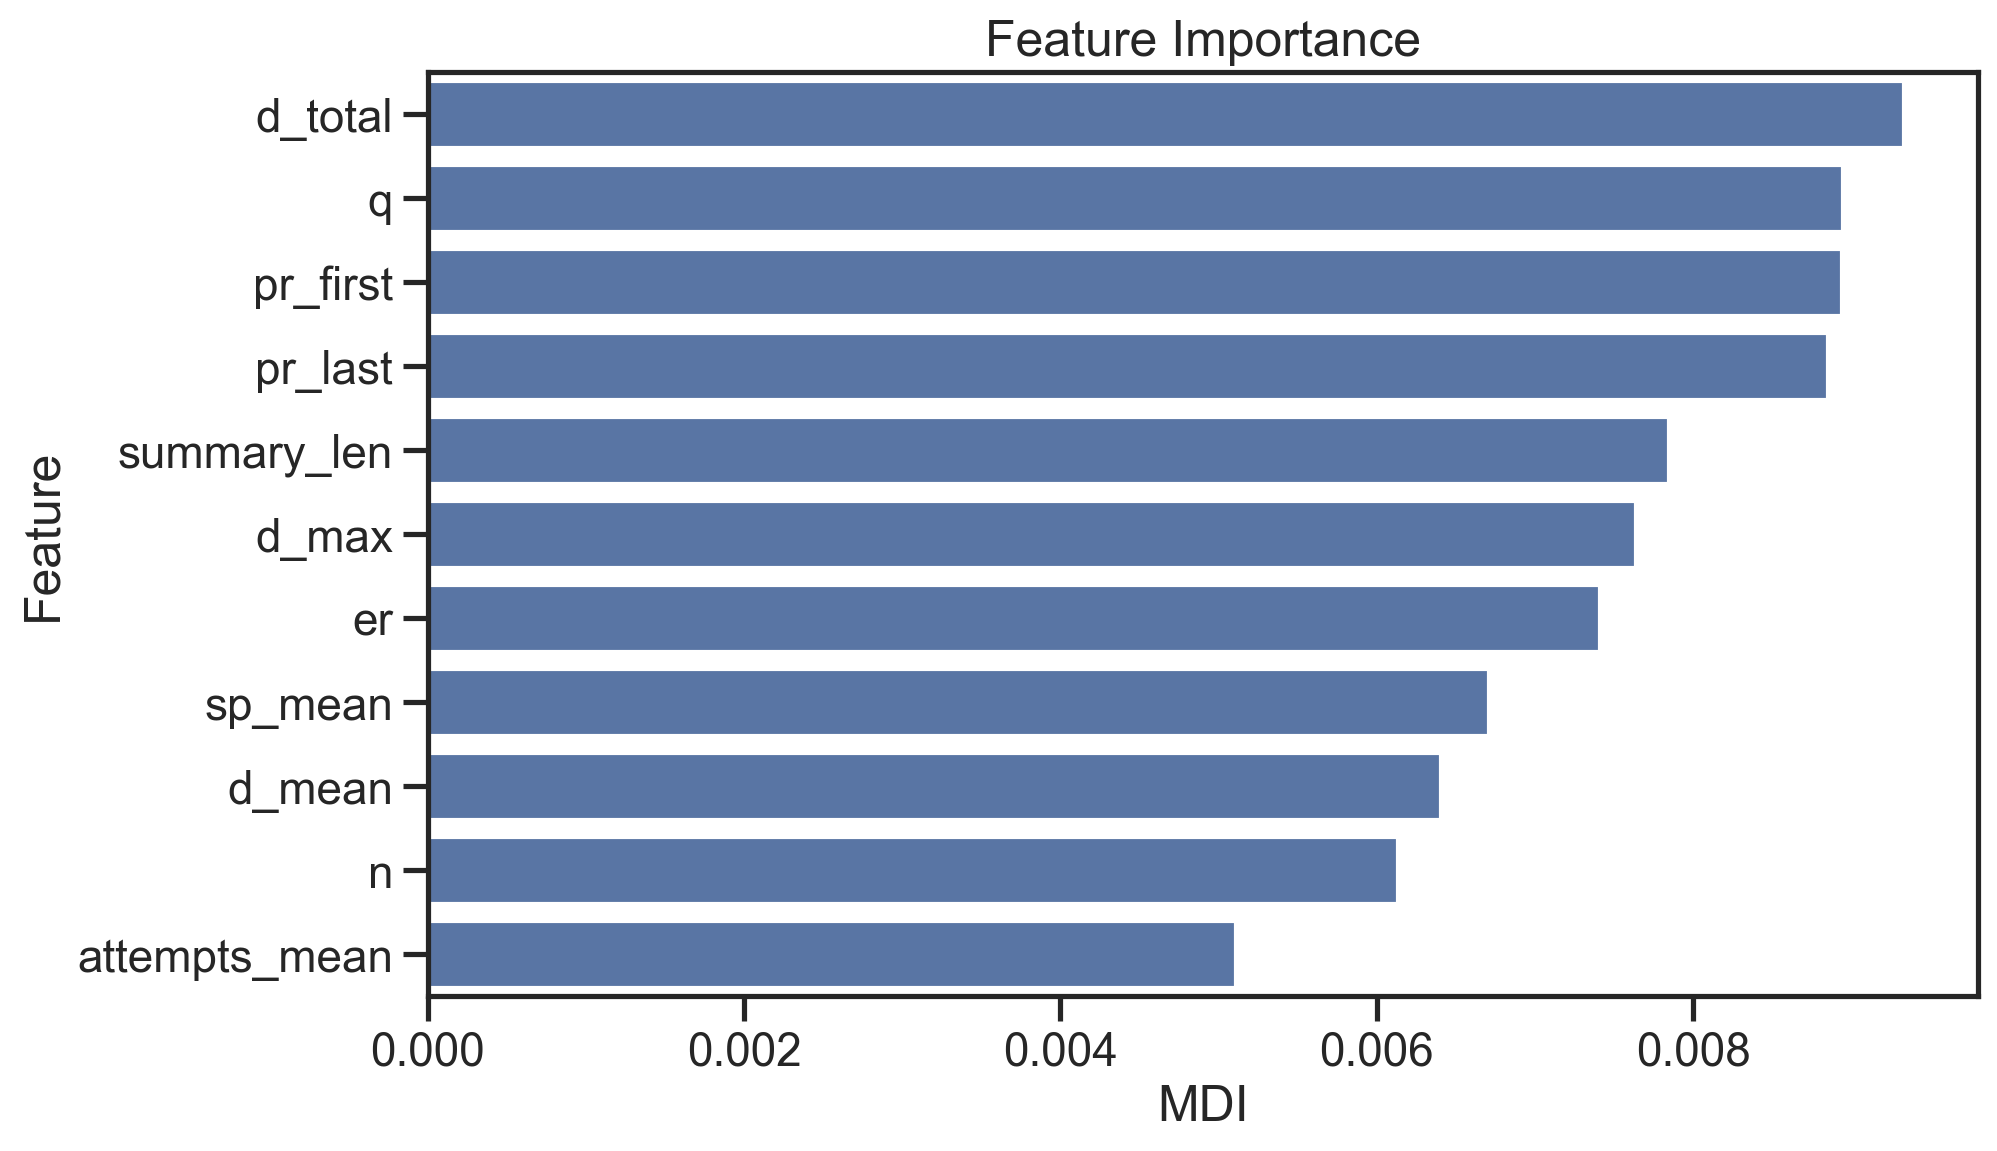

In [29]:
plot_feature_importance(augmented_model)

In [ ]:
class ChapterEnsembleModel(utils.BaseModel):
    """
    The model is an ensemble of 12 models, one for each chapter.
    Each model is trained on the features available up to the corresponding chapter.
    E.g. the model for chapter 3 is trained on the features of chapters 1, 2, and 3.

    During inference, we only use the model corresponding to the chapter being evaluated.

    Future work:
    Consider other ensemble strategies, e.g., majority voting, weighted voting, etc.
    """

    name = "Chapter Ensemble"

    def __init__(self, feature_cols):
        self.feature_cols = feature_cols

        # Prepare the features for each model, up to the corresponding chapter, i.e.
        # chapter_features[0]: features for chapter 1
        # chapter_features[1]: features for chapter 1 and 2
        # ...
        self.chapter_features = [
            [f for f in self.feature_cols if int(re.findall(r"\d+", f)[0]) <= chapter]
            for chapter in range(1, 13)
        ]

        self.models = []
        for chapter in range(1, 13):
            features = self.chapter_features[chapter - 1]
            self.models.append(utils.base_prediction_pipeline(features))

    def fit(self, X, y):
        for i, model in enumerate(self.models):
            features = self.chapter_features[i]
            model.fit(X[features], y)

    def predict_scores(self, X):
        # Infer the chapter number that is currently being evaluated by check the mask of X
        num_nan = X.iloc[0].isnull().sum()
        n_features = len(self.feature_cols) // 12
        n_chapter_being_masked = int(num_nan / n_features)
        chapter = 12 - n_chapter_being_masked

        # Use the corresponding model to predict the scores
        model = self.models[chapter - 1]
        features = self.chapter_features[chapter - 1]
        return model.predict_proba(X[features])[:, 1]

    def predict(self, X):
        scores = self.predict_scores(X)
        return scores > 0.5

In [ ]:
ensemble_metrics = evaluate_model(ChapterEnsembleModel, ucsd_data)

In [ ]:
ensemble_metrics

In [ ]:
from keras.callbacks import EarlyStopping


class SequenceModel(utils.BaseModel):
    """
    A RNN model that takes the sequence of features as input.
    """

    name = "Sequence"

    def __init__(self, feature_cols):
        self.feature_cols = feature_cols

        # The same data preprocessing pipeline as the BaseModel and all other models
        self.preprocessor = utils.preprocessing_pipeline(feature_cols)

        # Setup a GRU model for sequence data
        self.model = utils.create_sequence_model(
            rnn_cls="gru", dense_units=16, feature_cols=self.feature_cols
        )

    def fit(self, X, y):
        # Preprocess the augmented data and reshape it to sequence format
        X_train = self.preprocessor.fit_transform(X)
        n_features = len(self.feature_cols) // 12
        X_reshaped = X_train.reshape(-1, 12, n_features)

        early_stopping = EarlyStopping(
            monitor="val_roc_auc", patience=5, restore_best_weights=True
        )

        self.model.fit(
            X_reshaped,
            y,
            epochs=50,
            batch_size=64,
            verbose=0,
            callbacks=[early_stopping],
            validation_split=0.2,
        )

    def predict_scores(self, X):
        X_processed = self.preprocessor.transform(X)
        n_features = len(self.feature_cols) // 12
        X_reshaped = X_processed.reshape(-1, 12, n_features)

        return self.model.predict(X_reshaped, verbose=0)

    def predict(self, X):
        scores = self.predict_scores(X)
        return scores > 0.5

In [ ]:
sequence_metrics = evaluate_model(SequenceModel, ucsd_data)

In [ ]:
sequence_metrics

In [ ]:
class SequenceAugmentedModel(utils.BaseModel):
    """
    A RNN model that takes the sequence of features as input.
    """

    name = "Sequence Augmented"

    def __init__(self, feature_cols):
        self.feature_cols = feature_cols

        # The same data preprocessing pipeline as the BaseModel and all other models
        self.preprocessor = utils.preprocessing_pipeline(feature_cols)

        # Setup a GRU model for sequence data
        self.model = utils.create_sequence_model(
            rnn_cls="gru", dense_units=16, feature_cols=self.feature_cols
        )

    def fit(self, X, y):
        # Augment the X to simulate the reading progress, the same as AugmentedModel
        # Future chapters are masked with NaN values
        # ------ Data augmentation starts ------
        dfs = []
        for chapter in range(1, 13):
            features_to_mask = [
                f for f in self.feature_cols if int(re.findall(r"\d+", f)[0]) > chapter
            ]
            X_masked = X.copy()
            X_masked[features_to_mask] = np.nan
            dfs.append(X_masked)

        augmented_x = pd.concat(dfs, ignore_index=True)
        augmented_y = pd.concat([y] * 12, ignore_index=True)

        augmented_x = augmented_x.sample(frac=1)
        augmented_y = augmented_y[augmented_x.index]
        # ------ Data augmentation ends ------

        # Preprocess the augmented data and reshape it to sequence format
        X_train = self.preprocessor.fit_transform(augmented_x)
        n_features = len(self.feature_cols) // 12
        X_reshaped = X_train.reshape(-1, 12, n_features)

        early_stopping = EarlyStopping(
            monitor="val_roc_auc", patience=5, restore_best_weights=True
        )

        self.model.fit(
            X_reshaped,
            augmented_y,
            epochs=50,
            batch_size=64,
            verbose=0,
            callbacks=[early_stopping],
            validation_split=0.2,
        )

    def predict_scores(self, X):
        X_processed = self.preprocessor.transform(X)
        n_features = len(self.feature_cols) // 12
        X_reshaped = X_processed.reshape(-1, 12, n_features)

        return self.model.predict(X_reshaped, verbose=0)

    def predict(self, X):
        scores = self.predict_scores(X)
        return scores > 0.5

In [ ]:
sequence_augmented_metrics = evaluate_model(SequenceAugmentedModel, ucsd_data)

In [ ]:
sequence_augmented_metrics

In [ ]:
combined_metrics = pd.concat(
    [
        original_metrics,
        augmented_metrics,
        ensemble_metrics,
        sequence_metrics,
        sequence_augmented_metrics,
    ]
)

In [ ]:
utils.plot_metrics(combined_metrics, metrics_name="ROC_AUC")

In [ ]:
utils.plot_metrics(combined_metrics, metrics_name="Precision")

In [ ]:
utils.plot_metrics(combined_metrics, metrics_name="Recall")

In [ ]:
utils.plot_metrics(combined_metrics, metrics_name="PR_AUC")

# UCLA Data

Note: 
- We can only take the session A's data as session C is using a different version of the text book, causing the reading pattern to be way different.
- UCLA Session A and UCSD data are based on the same text book version.

In [30]:
ucla_data = utils.Dataset("ucla_session_a")

In [ ]:
ucla_metrics = pd.concat(
    [
        evaluate_model(utils.BaseModel, ucla_data),
        evaluate_model(AugmentedModel, ucla_data),
        evaluate_model(ChapterEnsembleModel, ucla_data),
        evaluate_model(SequenceModel, ucla_data),
        evaluate_model(SequenceAugmentedModel, ucla_data),
    ]
)

In [ ]:
utils.plot_metrics(ucla_metrics, metrics_name="ROC_AUC")

In [ ]:
utils.plot_metrics(ucla_metrics, metrics_name="PR_AUC")

In [37]:
_, ucla_augmented_model = evaluate_model(AugmentedModel, ucla_data)

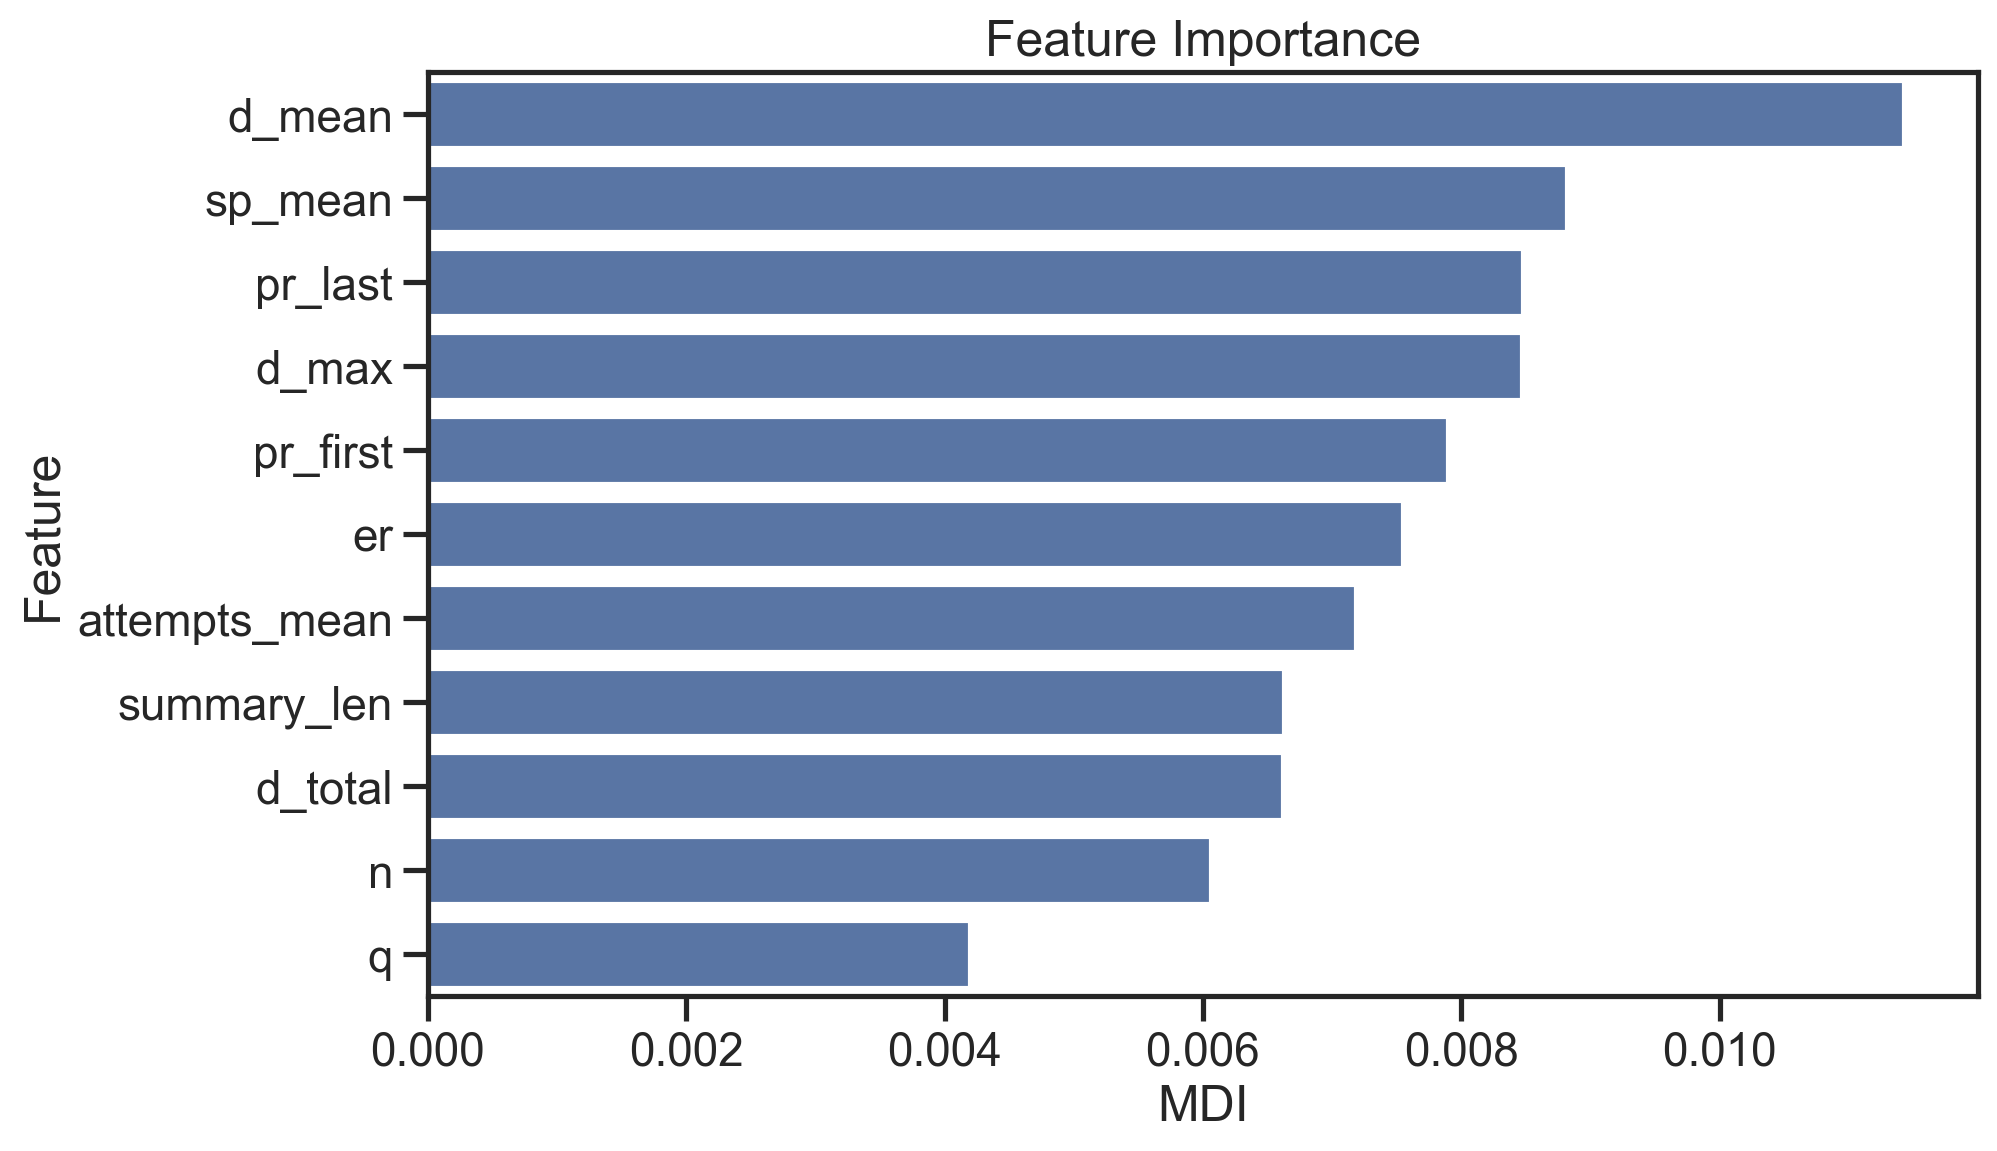

In [38]:
plot_feature_importance(ucla_augmented_model)

# Transfer from UCSD to UCLA

In this section, we tried to test the model's ability on predicting the reading pattern of UCLA students based on UCSD data. We will use the UCSD model to predict the reading pattern of UCLA students.

In [ ]:
import numpy as np
import pandas as pd


def evaluate_transfer(
    model_cls: Type[utils.BaseModel], train_data: pd.DataFrame, test_data: pd.DataFrame
) -> pd.DataFrame:
    # Train model using all the data from train_data
    feature_cols = train_data.feature_cols
    all_chapter_metrics: list[list[dict[str, float]]] = [[] for _ in range(12)]

    model = model_cls(feature_cols)
    model.fit(train_data.data, train_data.data["label"])

    # Test the model using all the data from test_data
    chapter_metrics = utils.compute_chapter_metrics(
        model, test_data.data[feature_cols], test_data.data["label"]
    )
    for i, chapter_metric in enumerate(chapter_metrics):
        all_chapter_metrics[i].append(chapter_metric)

    # Compute the average and standard deviation of the each metric
    metric_names = all_chapter_metrics[0][0].keys() - {"Chapter"}
    chapter_average_metrics = []
    chapter_std_metrics = []

    for chapter_metrics in all_chapter_metrics:
        average_metrics = {
            metric_name: np.mean([m[metric_name] for m in chapter_metrics])
            for metric_name in metric_names
        }
        std_metrics = {
            metric_name: np.std([m[metric_name] for m in chapter_metrics])
            for metric_name in metric_names
        }
        chapter_average_metrics.append(average_metrics)
        chapter_std_metrics.append(std_metrics)

    # Average metrics table
    table = pd.DataFrame(chapter_average_metrics)
    table["Model"] = model_cls.name
    table["Chapter"] = table.index + 1

    return table

In [ ]:
transfer_metrics = pd.concat(
    [
        evaluate_transfer(utils.BaseModel, ucsd_data, ucla_data),
        evaluate_transfer(AugmentedModel, ucsd_data, ucla_data),
        evaluate_transfer(ChapterEnsembleModel, ucsd_data, ucla_data),
        evaluate_transfer(SequenceModel, ucsd_data, ucla_data),
        evaluate_transfer(SequenceAugmentedModel, ucsd_data, ucla_data),
    ]
)

In [ ]:
utils.plot_metrics(transfer_metrics, metrics_name="ROC_AUC")

In [ ]:
utils.plot_metrics(transfer_metrics, metrics_name="PR_AUC")

In [ ]:
utils.plot_metrics(transfer_metrics, metrics_name="F1")